# Project Part 3: Using a Deep Learning Model for Small Talk Intent


In this part of the project, we will be training a deep learning model on our small talk intent data to see if we can improve our accuracy from part 2. As a reminder, we got as high as 75.46% accuracy in the previous part using a Gaussian Naive Bayes model. For this part, our model will be a distilbert model trained on emotion intent. This model by the user gokuls from huggingface, is trained on 16,000 observations which were phrases that were classifieid into 6 different emotion classes. Those include sadness, joy, love, anger, fear, and surprise. Our small talk intnent data has 84 different classes of small talk intent so it will be interesting to see how the model performs with this difference. We start off by importing the packages we will need and setup the data we have been using. 

Here is a link to the model:
https://huggingface.co/gokuls/distilbert-emotion-intent

Here is a link to the dataset it was trained on:
https://huggingface.co/datasets/emotion#data-instances


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-talk-intent-classification-data/Small_talk_Intent.csv


In [2]:
input_data_path = '../input/small-talk-intent-classification-data/Small_talk_Intent.csv'
df = pd.read_csv(input_data_path)

These next two blocks of code import and setup the model we have chose. In this case, we are importing the distilbert-emotion-intent model and pretraining it to handle 84 different observation classes. 

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  TrainingArguments, Trainer
from datasets import Dataset, load_metric

In [4]:
MODEL_NAME = "gokuls/distilbert-emotion-intent"
MAX_LENGTH=15

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=84, max_length=MAX_LENGTH, 
                                                           output_attentions=False, output_hidden_states=False, ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at gokuls/distilbert-emotion-intent and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([84, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([84]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This block lists our intents. Then it transfers each of the intents to a dictionary and ennumerates them so that they correspond to a given numerical value. Since we have 84 different observation classes, we will have a scale from 0 to 83 for our intent labels. You can see each of the labels and their corresponding numerical values listed below.

In [5]:
classes = df.Intent.unique().tolist()
class_tok2idx = dict((v, k) for k, v in enumerate(classes))
class_idx2tok = dict((k, v) for k, v in enumerate(classes))
print(class_tok2idx)
print(class_idx2tok)

{'smalltalk_agent_acquaintance': 0, 'smalltalk_agent_age': 1, 'smalltalk_agent_annoying': 2, 'smalltalk_agent_answer_my_question': 3, 'smalltalk_agent_bad': 4, 'smalltalk_agent_be_clever': 5, 'smalltalk_agent_beautiful': 6, 'smalltalk_agent_birth_date': 7, 'smalltalk_agent_boring': 8, 'smalltalk_agent_boss': 9, 'smalltalk_agent_busy': 10, 'smalltalk_agent_chatbot': 11, 'smalltalk_agent_clever': 12, 'smalltalk_agent_crazy': 13, 'smalltalk_agent_fired': 14, 'smalltalk_agent_funny': 15, 'smalltalk_agent_good': 16, 'smalltalk_agent_happy': 17, 'smalltalk_agent_hungry': 18, 'smalltalk_agent_marry_user': 19, 'smalltalk_agent_my_friend': 20, 'smalltalk_agent_occupation': 21, 'smalltalk_agent_origin': 22, 'smalltalk_agent_ready': 23, 'smalltalk_agent_real': 24, 'smalltalk_agent_residence': 25, 'smalltalk_agent_right': 26, 'smalltalk_confirmation_yes': 27, 'smalltalk_agent_sure': 28, 'smalltalk_agent_talk_to_me': 29, 'smalltalk_agent_there': 30, 'smalltalk_appraisal_bad': 31, 'smalltalk_apprais

Here is another check to make sure that our labels match the intents that they are supposed to.

In [6]:
df['label'] = df['Intent'].apply(lambda x: class_tok2idx[x])
df.head()

,Utterances,Intent,label
0,who are you?,smalltalk_agent_acquaintance,0
1,all about you,smalltalk_agent_acquaintance,0
2,what is your personality,smalltalk_agent_acquaintance,0
3,define yourself,smalltalk_agent_acquaintance,0
4,what are you,smalltalk_agent_acquaintance,0


This is a sample of what our model will see when training on the data.

In [7]:
ds_raw = Dataset.from_pandas(df[['label','Utterances']])
ds_raw[0]

{'label': 0, 'Utterances': 'who are you?'}

The tokenize_function below tokenizes and maps all of the observations so that our ds dataset has an attention_mask and input_ids for each observation.

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["Utterances"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

ds = ds_raw.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [9]:
ds[0]

{'label': 0,
 'Utterances': 'who are you?',
 'input_ids': [101, 2040, 2024, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

At this point, we can shuffle the data so that we can split it into training and validation data. We check the first observation to make sure that the data is shuffled and we will know this if we see a new observation than the one above. 

In [10]:
ds = ds.shuffle(seed=42)
ds[0]

{'label': 57,
 'Utterances': "i'm mad about this",
 'input_ids': [101,
  1045,
  1005,
  1049,
  5506,
  2055,
  2023,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

Below, we split the data so that 85% of it becomes the training for the distilbert-emotion-intent model and the other 15% will be used as a validation set to see how well the model predicts the small talk intent of each phrase. 

In [11]:
train_prop = 0.85
ds_train = ds.select(range(int(len(ds)*train_prop)))
ds_eval = ds.select(range(int(len(ds)*train_prop), len(ds)))

In [12]:
print(f"len(ds_train) = {len(ds_train)}")
print(f"len(ds_eval) = {len(ds_eval)}")

len(ds_train) = 2164
len(ds_eval) = 383


Finally, we can train the model on the data. The metric we will be using to measure the model will be accuracy. This is the most feasible one we can use with a classification problem like this one. I will be testing multiple different batch sizes and number of epochs to see which will yield the most accurate results with the least amount of loss.

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(num_train_epochs=8, 
                                  do_train=True,
                                  report_to=None,
                                  output_dir="/kaggle/working",
                                  evaluation_strategy="steps",
                                  eval_steps=500,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10)

trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = ds_train, 
                  eval_dataset = ds_eval,
                  compute_metrics = compute_metrics,
)

torch.set_grad_enabled(True)
trainer.train()
trainer.evaluate()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Utterances. If Utterances are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2164
  Num Epochs = 8
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps =

Step,Training Loss,Validation Loss,Accuracy
500,2.213400,0.886322,0.825065
1000,0.373400,0.415436,0.913838
1500,0.082200,0.406256,0.924282


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Utterances. If Utterances are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 383
  Batch size = 10
Saving model checkpoint to /kaggle/working/checkpoint-500
Configuration saved in /kaggle/working/checkpoint-500/config.json
Model weights saved in /kaggle/working/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Utterances. If Utterances are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 383
  Batch size = 10
Saving model checkpoint to /kaggle/working/checkpoint-1000
Configuration saved in /kaggle/working/ch

{'eval_loss': 0.3964862823486328,
 'eval_accuracy': 0.9268929503916449,
 'eval_runtime': 0.3065,
 'eval_samples_per_second': 1249.482,
 'eval_steps_per_second': 127.232,
 'epoch': 8.0}

Above you can see the most accurate settings for the distilbert-emotion-intent model on the small talk intent data. We yielded a 92.95% accuracy using 8 epochs and a batch size of 10. The table picture below shows all of the other epoch and batch sizes I tested to come to this conclusion. I am a bit surprised by this result, because of the difference in the number of observations classes between the data the model was trained versus the data I used. Although I do believe the results are accurate and make sense, because the core problem is pretty similiar between the two datasets so its probably not that big of a jump to go from using 6 observation classes to 84 for a deep learning model like distilbert-emotion-intent.  

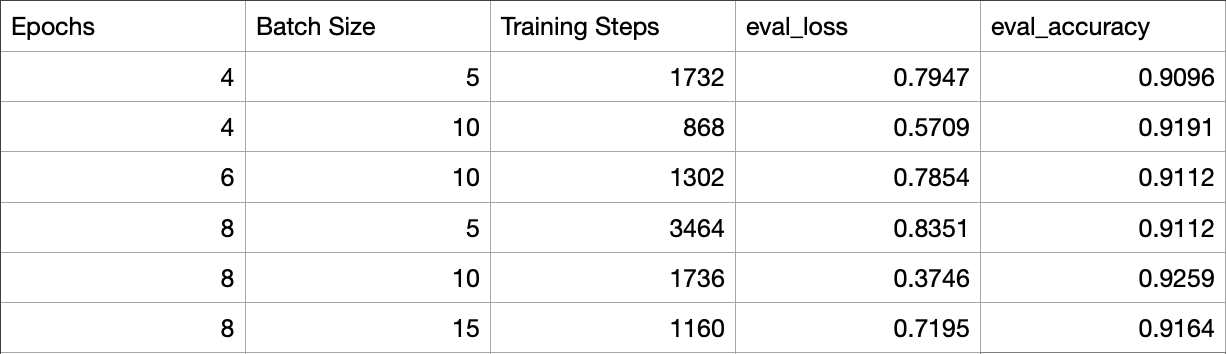